In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import cv2 as cv

import IPython.display as display
from PIL import Image

from sklearn.model_selection import train_test_split


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.__version__)

In [ ]:
colon_main = pd.read_csv("./Image_classification_data/data_labels_mainData.csv")

In [123]:
colon_main.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [5]:
colon_main.dtypes

InstanceID       int64
patientID        int64
ImageName       object
cellTypeName    object
cellType         int64
isCancerous      int64
dtype: object

In [6]:
colon_main.isnull().sum()

InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64

In [4]:
train_data, test_data = train_test_split(colon_main, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, \nVal Data: {}, \nTest Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, 
Val Data: 1979, 
Test Data: 1980


In [4]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [5]:
colon_extra = pd.read_csv("./Image_classification_data/data_labels_extraData.csv")

In [85]:
colon_extra.head()

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


In [6]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler

X, colon_extra['cellType'], = make_blobs(n_samples=10384, centers=4, n_features=1, random_state=0)


In [7]:
colon_extra.head()

,InstanceID,patientID,ImageName,isCancerous,cellType
0,12681,61,12681.png,0,None
1,12682,61,12682.png,0,None
2,12683,61,12683.png,0,None
3,12684,61,12684.png,0,None
4,12685,61,12685.png,0,None


In [7]:
colon_extra['cellType'] = colon_extra['cellType'].astype('str')

cell_predict_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

cell_predict_generator = cell_predict_datagen.flow_from_dataframe(
        dataframe=colon_extra,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 10384 validated image filenames belonging to 4 classes.


In [8]:
cell_model1 = load_model("predict_celltype_extra")

In [ ]:
cell_model1.evaluate(cell_predict_generator)

In [10]:
label_names = {'fibroblast': 0, 'inflammatory':1, 'epithelial': 2, 'others':3}

epithelial
epithelial
inflammatory
epithelial


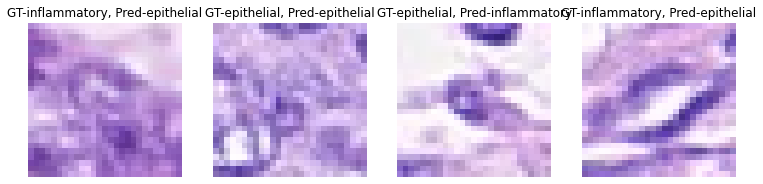

In [121]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in cell_predict_generator:
        batches = batches + 1
        y_hat = cell_model1.predict(x, verbose=0)
        
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            print(d_inv[np.argmax(y_hat[0])])
        else:
            break
        
        plt.axis('off')

In [ ]:
d_inv = {v: k for k, v in label_names.items()}
preds = []
for x,y in cell_predict_generator:
    y_hat = cell_model1.predict(x, verbose=0)
    preds.append(d_inv[np.argmax(y_hat[0])])

In [ ]:
preds

In [23]:
cell_type_model_reg_pred = load_model("predict_celltype_extra1.h5")

In [24]:
print(cell_type_model_reg_pred.input, cell_type_model_reg_pred.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 27, 27, 3), dtype=tf.float32, name='input_12'), name='input_12', description="created by layer 'input_12'") KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), name='dense_27/Softmax:0', description="created by layer 'dense_27'")


In [25]:
from tensorflow.keras.models import Model
model = Model(cell_type_model_reg_pred.input, cell_type_model_reg_pred.output)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 27, 27, 3)]       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 27, 27, 32)        2432      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 9, 9, 48)          38448     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 4, 4, 48)          0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 2, 2, 64)          27712     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 1, 1, 64)          0   

In [17]:
colon_extra['cellType'] = colon_extra['cellType'].astype('str')

cell_predict_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

cell_predict_generator = cell_predict_datagen.flow_from_dataframe(
        dataframe=colon_extra,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 10384 validated image filenames belonging to 4 classes.


In [27]:
model.evaluate(cell_predict_generator)

10384/10384 [==============================] - 22s 2ms/step - loss: 2.7947 - accuracy: 0.2500


[2.794696092605591, 0.25]

In [81]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
cell_type_model_reg_pred = load_model("predict_celltype_extra1.h5")
model = Model(cell_type_model_reg_pred.input, cell_type_model_reg_pred.output)

In [83]:
model.layers[0].trainable = False
# add new classifier layers
flat1 = Flatten()(cell_type_model_reg_pred.output)
class1 = Dense(1024, activation='relu')(flat1)
# define new model
model = Model(inputs=model.inputs, outputs=model.outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 27, 27, 3)]       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 27, 27, 32)        2432      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 9, 9, 48)          38448     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 4, 4, 48)          0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 2, 2, 64)          27712     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 1, 1, 64)          0   

In [47]:
FlattenImages = {
    'photo_name' : [],
    'flattenPhoto' : [],
    }

In [49]:
colon_extra['FlattenData'] = None
for img in colon_extra['ImageName']:
    FlattenImages['photo_name'].append(img)
    path = './Image_classification_data/patch_images/' + img
    img = cv.imread(path)
    img = cv.resize(img, (27, 27))
    ## Expanding image dims so this represents 1 sample
    img = img = np.expand_dims(img, 0)
    img = tf.keras.applications.resnet50.preprocess_input(img)
    extractedFeatures = model.predict(img)
    extractedFeatures = np.array(extractedFeatures)
    FlattenImages['flattenPhoto'].append(extractedFeatures.flatten())

In [106]:
Training_Feature_vector = np.array(FlattenImages['flattenPhoto'], dtype = 'float64')
from sklearn.cluster import AgglomerativeClustering
kmeans = AgglomerativeClustering(n_clusters = 4)
kmeans.fit(Training_Feature_vector)

AgglomerativeClustering(n_clusters=4)

In [57]:
dimReducedDataFrame = pd.DataFrame(Training_Feature_vector)
dimReducedDataFrame

,0,1,2,3
0,0.254837,0.255506,0.252567,0.23709
1,0.254837,0.255506,0.252567,0.23709
2,0.254837,0.255506,0.252567,0.23709
3,0.254837,0.255506,0.252567,0.23709
4,0.254837,0.255506,0.252567,0.23709
...,...,...,...,...
10379,0.254837,0.255506,0.252567,0.23709
10380,0.254837,0.255506,0.252567,0.23709
10381,0.254837,0.255506,0.252567,0.23709
10382,0.254837,0.255506,0.252567,0.23709


In [107]:
label = kmeans.fit_predict(Training_Feature_vector)

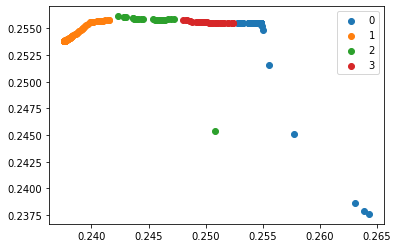

In [108]:
u_labels = np.unique(label)
#plotting the results:
for i in u_labels:
    plt.scatter(Training_Feature_vector[label == i, 0], Training_Feature_vector[label == i, 1], label = i)
plt.legend()
plt.show()